<a href="https://colab.research.google.com/github/yoshi-karino/my_kaggle/blob/main/230616_Kaggle_NYC_taxi_stacking5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

#from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, \
#    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [13]:
!ls -la


total 49104
drwxr-xr-x 1 root root     4096 Jun 16 08:10 .
drwxr-xr-x 1 root root     4096 Jun 16 07:30 ..
drwxr-xr-x 4 root root     4096 Jun 14 18:26 .config
drwxr-xr-x 1 root root     4096 Jun 14 18:27 sample_data
-rw-r--r-- 1 root root   983020 Jun 16 08:10 test.csv
-rw-r--r-- 1 root root 49283072 Jun 16 08:15 train_5per.csv


In [20]:
train1 = pd.read_csv('./train_5per.csv')
test1 = pd.read_csv('./test.csv')
train1.shape

(500923, 9)

In [21]:
data5p=pd.concat([train1, test1], axis=0)
#data5p=train1
data5p.shape


(510837, 9)

In [22]:
display(train1.shape)
display(test1.shape)
display(data5p.shape)

(500923, 9)

(9914, 7)

(510837, 9)

In [23]:
#6371 * ACOS(COS(緯度1*PI()/180) * COS(緯度2*PI()/180) * COS(経度2*PI()/180-経度1*PI()/180) +
#SIN(緯度1*PI()/180) * SIN(緯度2*PI()/180) )
# 53,614,669
# 1,809,187
# display(data5p[data5p ['pickup_latitude'] >= 40.79331038625757]

from math import cos
from math import sin
from math import acos
from math import pi


In [24]:
#値が 0, null のものを除外 (乗車地、降車値)
data5p = data5p[\
 (data5p['pickup_latitude'] != 0) & \
 (data5p['pickup_latitude'].notnull()) & \
 (data5p['pickup_longitude'] != 0) & \
 (data5p['pickup_longitude'].notnull()) & \
 (data5p['dropoff_latitude'] != 0) & \
 (data5p['dropoff_latitude'].notnull()) & \
 (data5p['dropoff_longitude'] != 0) & \
 (data5p['dropoff_longitude'].notnull())]

data5p['dropoff_longitude'].count()


500852

In [25]:
data5p [data5p ['fare_amount'].isnull()].count()


Unnamed: 0              0
key                  9914
fare_amount             0
pickup_datetime      9914
pickup_longitude     9914
pickup_latitude      9914
dropoff_longitude    9914
dropoff_latitude     9914
passenger_count      9914
dtype: int64

In [26]:
#緯度経度から距離計算
#https://keisan.casio.jp/exec/system/1257670779
#https://www.newyork.jp/%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A8%E3%83%BC%E3%82%AF-%E3%82%BF%E3%82%AF%E3%82%B7%E3%83%BC/

#6371 * ACOS(COS(緯度1*PI()/180) * COS(緯度2*PI()/180) * COS(経度2*PI()/180-経度1*PI()/180) +
#SIN(緯度1*PI()/180) * SIN(緯度2*PI()/180) )

#-73.844311	40.721319	-73.841610	40.712278
#緯度 : lo, 経度 : la
def get_distance(lo1, la1, lo2, la2):
    a = cos(lo1 * pi /180)
    b = cos(lo2 * pi/180)
    c = cos(la2 * pi/180-la1*pi/180)
    d = sin(lo1 * pi/180)
    e = sin(lo2 * pi/180)
    if (a * b * c + d * e) > 1 or (a * b * c + d * e) < -1:
      x=1
    else:
      x = 6378 * acos(a * b * c + d * e)
    return x
#a = get_distance(35.84533779636394, 140.02901301071623, 35.71411998128971, 139.7766630867319)
#a = get_distance(-73.844311, 40.721319, -73.841610, 40.712278)
#a = get_distance(40.795965739777536,  -73.46793131074821,  40.790813764196415, -73.36682627815249)
#-73.877028	40.756455	-73.877028	40.756455
a = get_distance(40.756455,  -73.877028,  40.756455, -73.877028)


In [27]:
#   距離
data5p ['dist'] = \
data5p[\
 (data5p['pickup_latitude'] != 0) & \
 (data5p['pickup_latitude'].notnull()) & \
 (data5p['pickup_longitude'] != 0) & \
 (data5p['pickup_longitude'].notnull()) & \
 (data5p['dropoff_latitude'] != 0) & \
 (data5p['dropoff_latitude'].notnull()) & \
 (data5p['dropoff_longitude'] != 0) & \
 (data5p['dropoff_longitude'].notnull())]\
 .apply(lambda x : get_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)


In [28]:
#時差調整 (NY時間にする)
import datetime

data5p['pickup_datetime'] = pd.to_datetime(data5p['pickup_datetime'])-datetime.timedelta(hours=4)

In [29]:
#年、月、日、時を出す
data5p['pickup_year'] = data5p['pickup_datetime'].dt.year
data5p['pickup_month'] = data5p['pickup_datetime'].dt.month
data5p['pickup_day'] = data5p['pickup_datetime'].dt.day
data5p['pickup_hour'] = data5p['pickup_datetime'].dt.hour


In [30]:
data5p.groupby('pickup_year')['fare_amount'].mean()


pickup_year
2008     9.770000
2009    10.012814
2010    10.120672
2011    10.474397
2012    11.158646
2013    12.491821
2014    12.912782
2015    12.934160
Name: fare_amount, dtype: float64

In [31]:
#以下インポート
#. 線形回帰 (二次用)
#. K近傍法 (一次用)
#. LGBM (一次用)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import math


In [32]:
#.  平日か°土日か (土日 =1)
import datetime
data5p ['satsun'] = data5p['pickup_datetime'].\
apply(lambda x : x.weekday()).\
apply(lambda x : 1 if x > 4 and x < 7 else 0 if x < 5 else 100)

#割り増し料金
#月曜から金曜の16:00から20:00 $2.50
#20:00から翌6:00の間 : $1

data5p['rush_hour'] = data5p.\
apply(lambda x : 2.5 if (x['pickup_hour']>=16) and (x['pickup_hour']<=19) and (x['satsun'] == 0) else 0, axis=1)

data5p['late_early'] = data5p.\
apply(lambda x : 1 if (x['pickup_hour']>=20) or (x['pickup_hour']<6) else 0, axis=1)


In [33]:
# This function return distance calcuated from 4 points
def haversine_np(lon1, lat1, lon2, lat2):

    """Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length."""

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [34]:
#名所ごとの距離
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude']);
    df[landmark_name + '_pickup_distance'] = haversine_np(lon, lat, df['pickup_longitude'], df['pickup_latitude']);

#for a_df in [train, test]:
for a_df in [data5p]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)


In [35]:
#↑ここまでで列の付け足しはおわり。なので提出用データと分離できる
# 訓練用
data5pt  = data5p [data5p ['fare_amount'].notnull()]

# 提出用
data5ps  = data5p [data5p ['fare_amount'].isnull()]

display(data5pt.shape)
display(data5ps.shape)


(490938, 27)

(9914, 27)

In [ ]:
data5pt = pd.read_csv('./data5pt.csv')
data5ps = pd.read_csv('./data5ps.csv')


(490938, 20)

(9914, 20)

In [37]:
display(data5pt.shape)
display(data5ps.shape)


(490938, 27)

(9914, 27)

In [38]:
#料金 <$1, >$500 を除外
# NY市内
#. 40 < latitude 42
#  -75 < longitude < -72
# 1 <= 乗客 <=6

def remove_outliers(df):
    return df[(df['fare_amount'] >=1.) &
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) &
              (df['pickup_longitude'] <= -72) &
              (df['dropoff_longitude'] >= -75) &
              (df['dropoff_longitude'] <= -72) &
              (df['pickup_latitude'] >= 40) &
              (df['pickup_latitude'] <= 42) &
              (df['dropoff_latitude'] >=40) &
              (df['dropoff_latitude'] <= 42) &
              (df['passenger_count'] >= 1) &
              (df['passenger_count'] <= 6)]


In [39]:
data5pt  = remove_outliers(data5pt)

In [40]:
data5pt.to_csv('./data5pt.csv')
data5ps.to_csv('./data5ps.csv')

20089

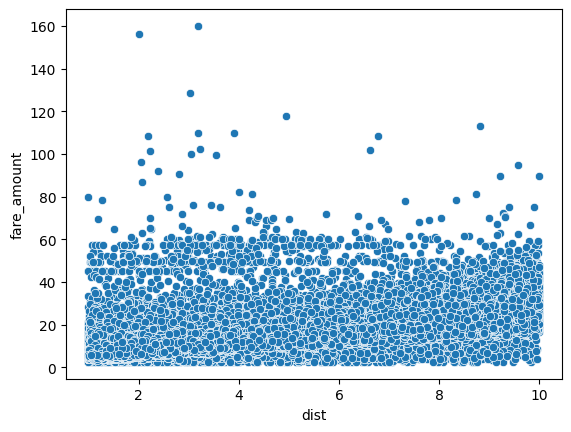

In [41]:
#距離と料金の相関
import seaborn as sns

sns.scatterplot(data=data5pt[(data5pt['dist'] >=1) & (data5pt['dist'] <=10) & (data5pt['dist'] <40)], y='fare_amount', x='dist')
data5pt[data5pt['fare_amount'] < 3.1]['fare_amount'].count()
display(data5pt[data5pt['dist']<0.5]['fare_amount'].count())


In [42]:
display(data5pt[data5pt['dist'] < 50][['dist', 'fare_amount']].corr())
data5pt.shape

,dist,fare_amount
dist,1.000000,0.860817
fare_amount,0.860817,1.000000


(488628, 27)

In [43]:
data5p.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'dist', 'pickup_year',
       'pickup_month', 'pickup_day', 'pickup_hour', 'satsun', 'rush_hour',
       'late_early', 'jfk_drop_distance', 'jfk_pickup_distance',
       'lga_drop_distance', 'lga_pickup_distance', 'ewr_drop_distance',
       'ewr_pickup_distance', 'met_drop_distance', 'met_pickup_distance',
       'wtc_drop_distance', 'wtc_pickup_distance'],
      dtype='object')

In [44]:
#訓練データから訓練、テストデータ用意
train, test = train_test_split(data5pt, test_size=0.2)

In [100]:
#clmgo = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', '96th1', '96th2', 'dist','satsun', 'rush_hour', 'late_early', 'pickup_year', 'pickup_month','pickup_day', 'pickup_hour']
#clmgo = ['pickup_longitude',
#       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#       'dist', 'pickup_year', 'pickup_month', 'pickup_day',
#       'pickup_hour', 'satsun', 'late_early', 'rush_hour','jfk_drop_distance', 'jfk_pickup_distance',
#       'lga_drop_distance', 'lga_pickup_distance','ewr_drop_distance',
#       'ewr_pickup_distance', 'met_drop_distance', 'met_pickup_distance',
#       'wtc_pickup_distance']

clmgo = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'dist', 'pickup_year', 'pickup_month', 'pickup_day',
       'pickup_hour','jfk_drop_distance', 'jfk_pickup_distance',
       'lga_drop_distance', 'lga_pickup_distance','ewr_drop_distance',
       'ewr_pickup_distance', 'met_drop_distance', 'met_pickup_distance',
       'wtc_pickup_distance']

trainx = train[clmgo].copy()
trainy = train['fare_amount'].copy()

testx = test[clmgo].copy()
testy = test['fare_amount'].copy()

data5ptX = data5pt[clmgo].copy()
data5ptY = data5pt['fare_amount'].copy()

data5psX = data5ps[clmgo].copy()
data5psY = data5ps['fare_amount'].copy()

display(trainx.shape)
display(testy.shape)

display(data5ptX.shape)
display(data5ptY.shape)


(390902, 18)

(97726,)

(488628, 18)

(488628,)

In [101]:
#data5pt ... 訓練データ
# trainx
#.trainy
# testx
#.testy

#data5ps ... 提出用データ

#RFR, KN, LGBインスタンス作成
#. trainx, trainy でfit (RFR, KN, LGB)
#. testx でpredict (RFR, KN, LGB) ... ①
#. data5ps で predict (RFR, KN, LGB) ... ②
#. ①(testx, testy)の結果を stack ... ③
#. ②(data5ps) の結果を stack ...④
#LinearRegressionインスタンス作成
#. ③(testx, testy利用) と testy で fit (LR)
#. ④(data5ps) で predict (LR)
trainx.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pickup_year,pickup_month,pickup_day,pickup_hour,jfk_drop_distance,jfk_pickup_distance,lga_drop_distance,lga_pickup_distance,ewr_drop_distance,ewr_pickup_distance,met_drop_distance,met_pickup_distance,wtc_pickup_distance
440268,-73.991520,40.726822,-73.983535,40.783787,6.376826,2013,6,6,16,23.455189,20.341083,9.248658,11.350836,19.191975,15.961990,1.779171,6.310387,2.212258
296961,-73.982753,40.731066,-73.946311,40.772682,5.559177,2014,11,17,2,20.345550,19.922351,6.103220,10.476237,21.323155,16.799246,1.605375,5.617653,3.072154
18180,-74.009061,40.704310,-74.005275,40.722424,2.041546,2012,4,25,9,21.160542,20.686914,12.600776,13.942162,14.717562,14.035335,7.254881,9.194458,0.923934
24863,-73.956595,40.778075,-73.968534,40.750648,3.214805,2011,2,10,9,20.126655,21.379500,8.474611,6.951566,18.630310,20.822034,3.226510,0.574974,8.548628
412333,-73.992958,40.749320,-73.986260,40.758895,1.206262,2011,9,25,7,21.870340,21.720787,9.657539,10.471018,17.629130,16.672576,2.993086,4.176888,4.322726


In [102]:
from sklearn.preprocessing import PolynomialFeatures

poly2d = PolynomialFeatures(2,interaction_only=True)
trainx_poly = poly2d.fit_transform(trainx)
testx_poly = poly2d.transform(testx)
data5psX_poly = poly2d.transform(data5psX)

In [103]:
trainx_poly_df = pd.DataFrame(data=trainx_poly)
testx_poly_df = pd.DataFrame(data=testx_poly)
data5psX_poly_df = pd.DataFrame(data=data5psX_poly)
data5psX_poly_df.head()

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
0,1.0,-73.973320,40.763805,-73.981430,40.743835,2.325812,2015.0,1.0,27.0,9.0,...,326.932353,73.540791,33.494644,112.236785,79.903535,36.392598,121.947503,8.186221,27.431105,12.493680
1,1.0,-73.986862,40.719383,-73.998886,40.739201,2.428018,2015.0,1.0,27.0,9.0,...,255.030388,84.996445,109.901718,32.868464,86.949034,112.426446,33.623538,37.469450,11.206042,14.489585
2,1.0,-73.982524,40.751260,-73.979654,40.746139,0.619308,2011.0,10.0,8.0,7.0,...,308.729453,69.375702,61.952406,85.694584,69.329846,61.911456,85.637941,13.912345,19.244009,17.184873
3,1.0,-73.981160,40.767807,-73.990448,40.751635,1.963187,2012.0,12.0,1.0,17.0,...,313.272783,65.236341,33.700608,111.911317,70.970337,36.662748,121.747845,7.634699,25.352933,13.097137
4,1.0,-73.966046,40.789775,-73.988565,40.744427,5.393220,2012.0,12.0,1.0,17.0,...,349.436564,74.530006,19.791977,156.935649,92.185887,24.480623,194.113119,5.221380,41.401655,10.994506


In [111]:
#RFR, KN, LGBインスタンス作成
#trainx, trainy でfit (RFR, KN, LGB)
#RandomForest
from sklearn.ensemble import GradientBoostingRegressor

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(trainx, trainy)

#K近傍法
kn = KNeighborsRegressor()
kn.fit(trainx, trainy)

#LGBMRegressor
lgb = LGBMRegressor()
lgb.fit(trainx, trainy)

gbr = GradientBoostingRegressor()
gbr.fit(trainx, trainy)


GradientBoostingRegressor()

In [112]:
xgb = XGBRegressor()
xgb.fit(trainx, trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [113]:
#15:07-15:20
xgb_p = XGBRegressor()
xgb_p.fit(trainx_poly_df, trainy)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [114]:
#testx でpredict (RFR, KN, LGB) ... ①
#15:21-15:23
ytest_pred_rfr = rfr.predict(testx)
ytest_pred_kn = kn.predict(testx)
ytest_pred_lgb = lgb.predict(testx)
ytest_pred_xgb = xgb.predict(testx)
ytest_pred_gbr = gbr.predict(testx)
ytest_pred_xgb_p = xgb_p.predict(testx_poly_df)

display(np.sqrt(mean_squared_error(testy, ytest_pred_rfr)))
display(np.sqrt(mean_squared_error(testy, ytest_pred_kn)))
display(np.sqrt(mean_squared_error(testy, ytest_pred_lgb)))
display(np.sqrt(mean_squared_error(testy, ytest_pred_xgb)))
display(np.sqrt(mean_squared_error(testy, ytest_pred_gbr)))
display(np.sqrt(mean_squared_error(testy, ytest_pred_xgb_p)))

#3.7303997342422277
#4.792474518988727
#3.7494206081680295
#3.6807208314906426

#3.8874980332733653
#4.412783535465106
#3.8507086639436063
#3.7943826808290173
#4.045380691784848

#3.883625428887753
#4.403251424180471
#3.8660269611385885
#3.8257819289843713
#4.030466374436798

#3.8398107749683468 rfr
#4.36644468552393.  kn
#3.7495445544720187.lgb
#3.731805199214424. xgb
#3.9303694158087765.gbr
#3.722072336617572. xgb (PolynomialFeatures)

#omitted : 'satsun', 'late_early', 'rush_hour'
#3.8128264698993983 rfr
#4.356847902732569  kn
#3.7421533627943373 lgb
#3.762958948827867. xgb
#3.9324730525850846.gbr
#3.720382169629585. xgb (PolynomialFeatures)


3.8128264698993983

4.356847902732569

3.7421533627943373

3.762958948827867

3.9324730525850846

3.720382169629585

In [115]:
#. ①(testx, testy)の結果を stack ... ③
#stack_test = np.column_stack( [ytest_pred_rfr, ytest_pred_kn, ytest_pred_lgb,ytest_pred_xgb, ytest_pred_gbr,ytest_pred_xgb_p])
stack_test = np.column_stack( [ytest_pred_rfr, ytest_pred_lgb,ytest_pred_xgb, ytest_pred_gbr,ytest_pred_xgb_p])
stack_test.shape


(97726, 5)

In [116]:
#data5psX で predict (RFR, KN, LGB, XGB, GBR, XGB_P) ... ②
#. ②(data5ps) の結果を stack ...④
y5ps_pred_rfr = rfr.predict(data5psX)
y5ps_pred_kn = kn.predict(data5psX)
y5ps_pred_lgb = lgb.predict(data5psX)
y5ps_pred_xgb = xgb.predict(data5psX)
y5ps_pred_gbr = gbr.predict(data5psX)
y5ps_pred_xgb_p = xgb_p.predict(data5psX_poly_df)


In [94]:
#stack_5ps = np.column_stack( [y5ps_pred_rfr, y5ps_pred_kn,y5ps_pred_lgb,y5ps_pred_xgb,y5ps_pred_gbr,y5ps_pred_xgb_p])
stack_5ps = np.column_stack( [y5ps_pred_rfr, y5ps_pred_lgb,y5ps_pred_xgb,y5ps_pred_gbr,y5ps_pred_xgb_p])
stack_5ps.shape


(9914, 5)

In [117]:
#LinearRegressionインスタンス作成
lr = LinearRegression()

#. ③(testx, testy利用) と testy で fit (LR)
lr.fit(stack_test, testy)


#. ④(data5ps) で predict (LR)
final_pred = lr.predict(stack_5ps)

In [118]:
final_pred.shape
sample = pd.read_csv('./sample_submission.csv')
sample.shape

(9914, 2)

In [119]:
sample['fare_amount'] = final_pred


In [120]:
sample.to_csv('./submission_stacking_0616h.csv',index=False)
